In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from plotting_tools import * 
import geopandas as gpd

In [2]:
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
#import matplotlib.cm as cm
from shapely.geometry import Point
from shapely.ops import nearest_points
import numpy as np

from matplotlib import gridspec


In [7]:
%config InlineBackend.print_figure_kwargs = {'dpi': 110, 'bbox_inches': 'tight'}

In [3]:
gebiete = gpd.read_file("MunichModel_shape/Gebiete.shp")
abschnitte = gpd.read_file(f"MunichModel_shape/one_point_concentration/Abschnitte.shp")

knoten_timepoints = ["1030_min", "1110_min", "1360_min", "1955_min"]
knoten_1 = gpd.read_file(f"MunichModel_shape/one_point_concentration/{knoten_timepoints[0]}.shp")
knoten_2 = gpd.read_file(f"MunichModel_shape/one_point_concentration/{knoten_timepoints[1]}.shp")
knoten_3 = gpd.read_file(f"MunichModel_shape/one_point_concentration/{knoten_timepoints[2]}.shp")
knoten_4 = gpd.read_file(f"MunichModel_shape/one_point_concentration/{knoten_timepoints[3]}.shp")

messstellen = gpd.read_file("MunichModel_shape/Knoten.shp")


knoten_1["Stoffkonze"] = knoten_1.Stoffkonze.astype('float')
knoten_2["Stoffkonze"] = knoten_2.Stoffkonze.astype('float')
knoten_3["Stoffkonze"] = knoten_3.Stoffkonze.astype('float')
knoten_4["Stoffkonze"] = knoten_4.Stoffkonze.astype('float')


In [4]:
knoten_list = [knoten_1, knoten_2, knoten_3, knoten_4]

In [5]:
# Function to find nearest node
def find_nearest_node(point, knoten_gdf):
    distances = knoten_gdf.geometry.distance(point)
    nearest_idx = distances.idxmin()
    return knoten_gdf.loc[nearest_idx, 'Stoffkonze']


def densify_line(line, num_points=20):
    """Interpolates points along a LineString."""
    return [line.interpolate(float(i)/num_points, normalized=True) for i in range(num_points + 1)]

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from shapely.ops import unary_union

# to create a boarder for munich
union_geom = unary_union(gebiete.geometry)
union_gdf = gpd.GeoDataFrame(geometry=[union_geom], crs=gebiete.crs)


colors = ["lightslategrey", "goldenrod", "red"]
cmap = LinearSegmentedColormap.from_list("blue_yellow_red", colors)

# Set up GridSpec to add a 5th column for the colorbar
fig = plt.figure(figsize=(11*cm, 5*cm), dpi=300)
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.1)
axs = [fig.add_subplot(gs[0, i]) for i in range(4)]

# Define colormap and normalization
#cmap = plt.cm.seismic
norm = mcolors.Normalize(vmin=0, vmax=10000)

xlabels = ["t1", "t2", "t3", "t4"]

for j, ax in enumerate(axs):
    knoten = knoten_list[j]

    value_from_list = []
    value_to_list = []

    for geom in abschnitte.geometry:
        start_point = Point(geom.coords[0])
        end_point = Point(geom.coords[-1])

        value_from = find_nearest_node(start_point, knoten)
        value_to = find_nearest_node(end_point, knoten)

        value_from_list.append(value_from)
        value_to_list.append(value_to)

    abschnitte['value_from'] = value_from_list
    abschnitte['value_to'] = value_to_list

    union_gdf.plot(ax=ax, color='lightgrey', edgecolor="black", linewidth=1, alpha=0.2)

    messstellen.plot(ax=ax, color='grey', zorder=20, markersize=1, alpha=0.01)
    markers = ['^', "*", 'o', 's', '^']  # Example: circle, square, triangle up
    messstellen.iloc[[1]].plot(ax=ax, color='#1c4587', zorder=20, markersize=40, marker="*")
    messstellen.iloc[[8]].plot(ax=ax, color='#1c4587', zorder=20, markersize=20, marker="^")
    messstellen.iloc[[11]].plot(ax=ax, color='#1c4587', zorder=20, markersize=20, marker="o")

    for idx, row in abschnitte.iterrows():
        line = row.geometry
        value_start = row['value_from']
        value_end = row['value_to']

        points = densify_line(line, num_points=40)
        segments = []
        colors = []

        for i in range(len(points) - 1):
            seg = [(points[i].x, points[i].y), (points[i+1].x, points[i+1].y)]
            segments.append(seg)

            interp = i / (len(points) - 2)
            value = (1 - interp) * value_start + interp * value_end
            colors.append(cmap(norm(value)))

        # Set linewidth: 1.5 if value is not zero, else 1.0
        linewidths = [1.5 if v != 0 else 1.0 for v in np.linspace(value_start, value_end, len(segments))]
        lc = LineCollection(segments, colors=colors, linewidths=linewidths)
        ax.add_collection(lc)

    """
    row = messstellen.iloc[[1]]
    ax.annotate(text="S_Ub", xy=(row.geometry.x, row.geometry.y),
                xytext=(-7, -5), textcoords="offset points", ha="right", color="green")
    
    row = messstellen.iloc[[11]]
    ax.annotate(text="S_M2", xy=(row.geometry.x, row.geometry.y),
                xytext=(-7, -5), textcoords="offset points", ha="right", color="green")
    
    row = messstellen.iloc[[6]]
    ax.annotate(text="SCE_D2", xy=(row.geometry.x, row.geometry.y),
                xytext=(-7, -5), textcoords="offset points", ha="right", color="green")
    """ 

    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_xlabel(f"{(knoten_timepoints[j]).replace('_', ' ')}")
    ax.set_xlabel(f"{xlabels[j]}", fontsize=0.8*15)
    ax.set_ylabel("")

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Use the last subplot (axs[-1]) as anchor for placement
ax_for_cbar = axs[-1]

# Create a colorbar axis inset to the right of the last plot
cax = inset_axes(ax_for_cbar,
                 width="5%",  # width of the colorbar relative to ax
                 height="100%",  # match subplot height
                 loc='center left',
                 bbox_to_anchor=(1.05, 0., 1, 1),  # shift right of plot
                 bbox_transform=ax_for_cbar.transAxes,
                 borderpad=0)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("concetration")

plt.show()
fig.savefig("../plots/overview_maps/one_point_concentration_part_1.png", bbox_inches='tight', dpi=300)

Note: In theory there should only be colouring downstream, not to the connected edges of the direct line to downstream. However, both in ++systems as well as here this is an artefact of the plotting setting. 
Solve by either adding additional measurement stations, introducing water (probably takes ages)
or by overlaying some components with a second one. 

In [32]:
# Gut Großlappen
df_S_D2 = pd.read_csv("MunichModel_shape/one_point_concentration/MUC596.txt", sep="\t", decimal=",").reset_index()
df_S_D2.columns = ["time_in_min", "concentration"]

# Leopoldstraße
df_S_M2 = pd.read_csv("MunichModel_shape/one_point_concentration/MUC600.txt", sep="\t", decimal=",").reset_index()
df_S_M2.columns = ["time_in_min", "concentration"]

# add Sampling location
df_S_Ub = pd.read_csv("MunichModel_shape/one_point_concentration/MUC612.txt", sep="\t", decimal=",").reset_index()
df_S_Ub.columns = ["time_in_min", "concentration"]

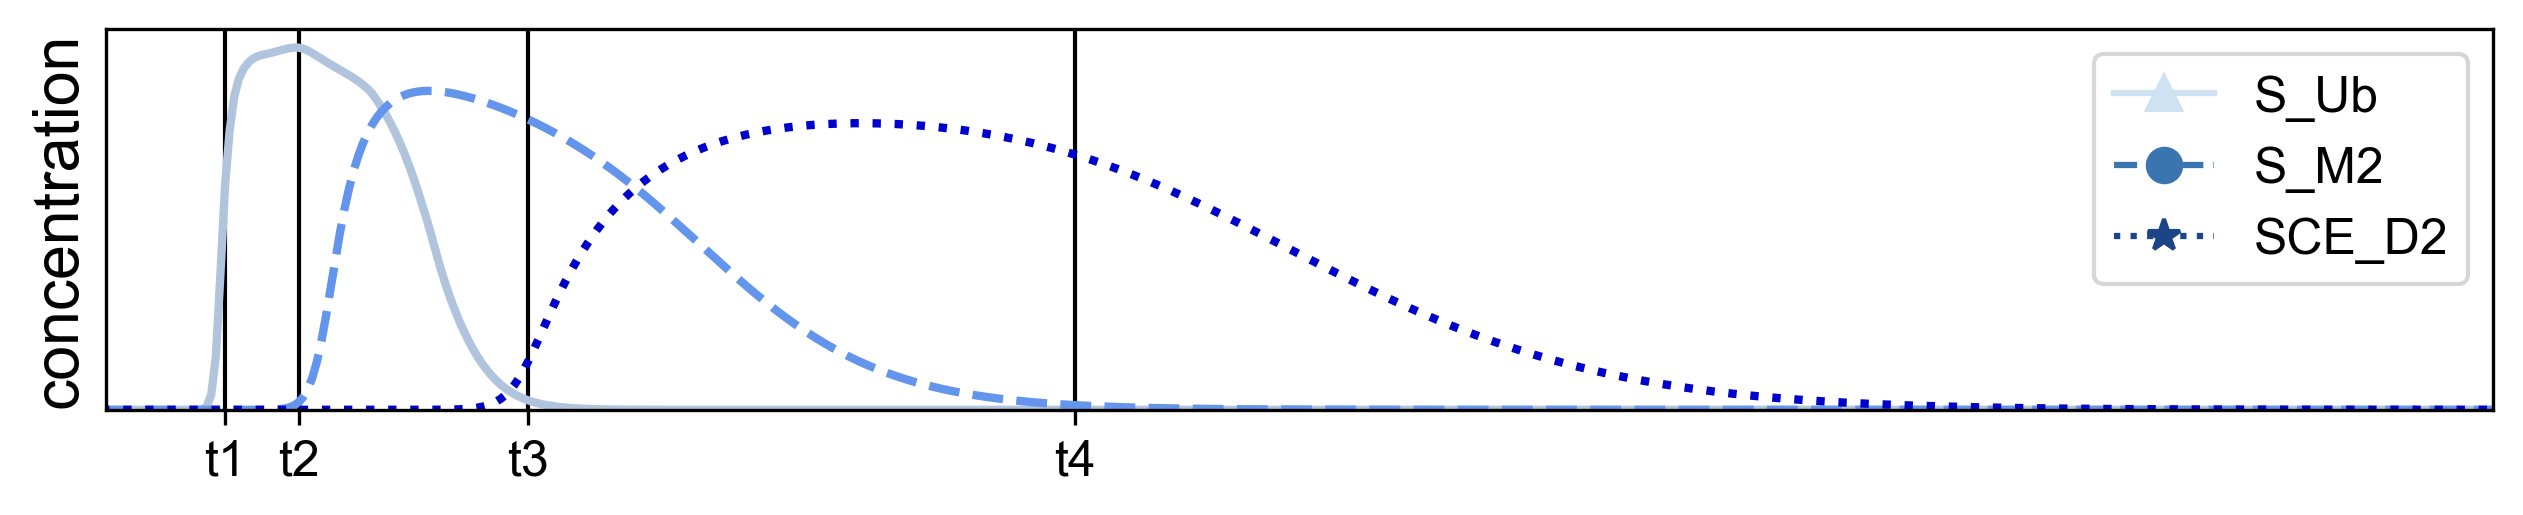

In [33]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(11*cm, 2.5*cm), dpi=300)

# Extract timepoints from knoten_timepoints
timepoints = [float(el.split("_")[0]) for el in knoten_timepoints]

# Add vertical lines at timepoints
for x in timepoints:
    ax.axvline(x=x, color="black", linestyle="-", linewidth=1)

# Plot curves
line1, = ax.plot(df_S_Ub["time_in_min"], df_S_Ub["concentration"],
                 label="S_Ub", color="lightsteelblue", linewidth=2, linestyle="-")
line2, = ax.plot(df_S_M2["time_in_min"], df_S_M2["concentration"],
                 label="S_M2", color="cornflowerblue", linewidth=2, linestyle="--")
line3, = ax.plot(df_S_D2["time_in_min"], df_S_D2["concentration"],
                 label="SCE_D2", color="mediumblue", linewidth=2, linestyle=":")

# Custom legend handles with different markers
custom_handles = [
    Line2D([0], [0], color="#cfe2f3", linestyle="-", marker='^', markersize=8, label="S_Ub"),
    Line2D([0], [0], color="#3b75af", linestyle="--", marker='o', markersize=8, label="S_M2"),
    Line2D([0], [0], color="#1c4587", linestyle=":", marker='*', markersize=8, label="SCE_D2"),
]

# Customize axes
ax.legend(handles=custom_handles)
ax.set_xlim(900, 3500)
ax.set_yticks([])
ax.set_ylabel("concentration")

# Add x-ticks at the timepoints
ax.set_xticks(timepoints)
ax.set_xticklabels(xlabels)

ax.set_ylim(0)
plt.tight_layout()

fig.savefig("../plots/overview_maps/one_point_concentration_part_2.png", bbox_inches='tight', dpi=300)
